# Solve 3D
Solving 2+1 dimensional system on cartesion (in time) mesh, sequentually for each time slab

## Define Functions

In [1]:
import sys
sys.path.append("..")
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
from DGeq import *
from prodmesh import *
import time
from netgen.geom2d import unit_square

In [2]:
def SolveWaveeq(fes,fullsys,mesh):
    sq = sqrt(0.5)
    truesol = sin( c*z+sq*(x+y) )
    v0 = c*cos(c*z+sq*(x+y))
    sig0 = CoefficientFunction(( -sq*cos(c*z+sq*(x+y)),-sq*cos(c*z+sq*(x+y)) ))
    gradtruesol = CoefficientFunction( (-sig0[0],-sig0[1], v0) )
    
    gfu = GridFunction(fes)
    gfu.Set(truesol) 
    gD = v0
    
    t = 0
    while t*t_stepsize<finaltime:
        t+=1
        gD = c*cos(c*(z+t*t_stepsize)+sq*(x+y))
        start = time.clock()
        [a,f] = DGeqsys(fes,gfu,0,0,c,gD,False,True)
        #print("DGsys: ", str(time.clock()-start))

        start = time.clock()
        [gfu, cond] = DGsolve(fes,a,f)
        #print("DGsolve: ", str(time.clock()-start))

        truesol = sin(c*(z+t*t_stepsize)+sq*(x+y))
        gradtruesol = CoefficientFunction( (sq*cos(c*(z+t*t_stepsize)+sq*(x+y)),sq*cos(c*(z+t*t_stepsize)+sq*(x+y)),c*cos(c*(z+t*t_stepsize)+sq*(x+y)) ) )
        L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
        sH1error = sqrt(Integrate((gradtruesol - grad(gfu))*(gradtruesol - grad(gfu)), mesh))
    
    print("timesteps: " + str(t))
    dof=fes.ndof#/mesh.ne
    cond = 1
    return [dof,cond,L2error,sH1error]

## Run comparison

In [3]:
c = 2
order = 4
k = 1
max_meshsize = 7

#mesh = ProdMesh(ngmeshbase,t_steps)

solution = []
meshsize = [0.5,0.4,0.3,0.25,0.2]

for ordr in meshsize:
    print("MESHSIZE:" + str(ordr))
      
    basemeshsize = ordr
    t_stepsize_small = basemeshsize / c * 0.8
    fak_t_stepsize_big = 5
    t_stepsize_big = t_stepsize_small * fak_t_stepsize_big 
    n_t_stepsize_small = 10
    finaltime = t_stepsize_small * n_t_stepsize_small
    ngmeshbase = unit_square.GenerateMesh(maxh = basemeshsize)
    print("finaltime: " + str(finaltime) + " big step size: " + str(t_stepsize_big) + " small step size: " + str(t_stepsize_small) + " wave number: " + str(c) + " space mesh size: " + str(basemeshsize) + " ststep*c: " + str(t_stepsize_small * c))
    
    t_stepsize = t_stepsize_big
    mesh = PeriodicProdMesh(ngmeshbase,t_stepsize)
    fes = FESpace("trefftzfespace", mesh, order = order, wavespeed = c, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False, mesh)
    solution.append([1,1/ordr,dof*n_t_stepsize_small/fak_t_stepsize_big,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))
    
    t_stepsize = t_stepsize_small
    mesh = PeriodicProdMesh(ngmeshbase,t_stepsize)
    fes = FESpace("trefftzfespace", mesh, order = order, wavespeed = c, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False, mesh)
    solution.append([2,1/ordr,dof*n_t_stepsize_small,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

MESHSIZE:0.5
finaltime: 2.0 big step size: 1.0 small step size: 0.2 wave number: 2 space mesh size: 0.5 ststep*c: 0.4
timesteps: 2
btype: Trefftz dof: 150 cond: 1 L2error: 0.0013448929543875268 H1error: 0.01405277181190258
timesteps: 10
btype: Trefftz dof: 150 cond: 1 L2error: 8.723759227539186e-06 H1error: 6.155636460141795e-05
MESHSIZE:0.4
finaltime: 1.6000000000000003 big step size: 0.8000000000000002 small step size: 0.16000000000000003 wave number: 2 space mesh size: 0.4 ststep*c: 0.32000000000000006
timesteps: 2
btype: Trefftz dof: 500 cond: 1 L2error: 0.0003791802483526577 H1error: 0.002418061058129511
timesteps: 10
btype: Trefftz dof: 500 cond: 1 L2error: 1.152355240789544e-06 H1error: 1.446249541439677e-05
MESHSIZE:0.3
finaltime: 1.2 big step size: 0.6 small step size: 0.12 wave number: 2 space mesh size: 0.3 ststep*c: 0.24
timesteps: 2
btype: Trefftz dof: 750 cond: 1 L2error: 0.00010918711555835966 H1error: 0.0016120504353594916
timesteps: 10
btype: Trefftz dof: 750 cond: 1 L

## Draw Comparison

In [4]:
def abline(slope, intercept,offset):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = np.exp(intercept + slope * x_vals)
    plt.plot(x_vals+offset, y_vals, '--', label="Slope "+str(slope))

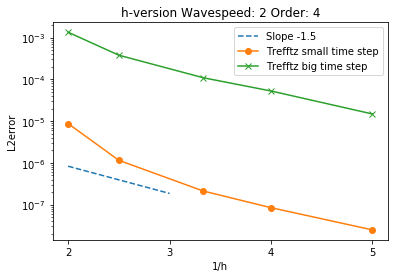

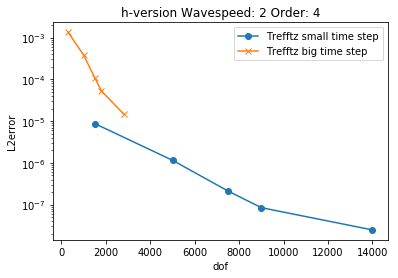

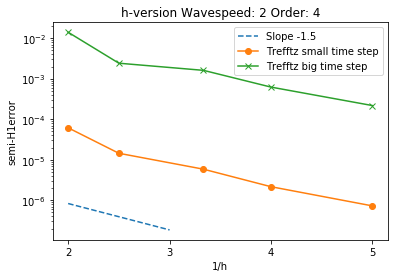

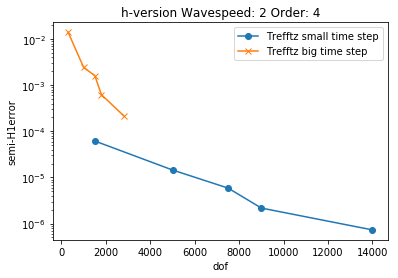

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

label = ['',"1/h",'dof','condition', 'L2error', 'semi-H1error']
sol = np.array(solution)

for yaxis in [4,5]:
    for xaxis in [1,2]:
        fig = plt.figure()
        ax = fig.gca()
        if(xaxis==1):
            abline(-order+2.5,-14,2)
        plt.semilogy(sol[sol[:,0]==2,xaxis], sol[sol[:,0]==2,yaxis], '-o', label="Trefftz small time step")
        plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '-x', label="Trefftz big time step")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('h-version' + ' Wavespeed: ' + str(c) + ' Order: ' + str(order))
        plt.legend()
        plt.ylabel(label[yaxis])
        plt.xlabel(label[xaxis])
        plt.savefig("results/3Dstepsize_h_"+label[yaxis]+label[xaxis].replace("/","o")+".png")
        plt.show()